In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [9]:
data=pd.read_csv(r"C:\Users\HP\Downloads\train.csv\train.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [10]:
data.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [11]:
data['date']=pd.to_datetime(data['date'])   # Convert the 'date' column to datetime format

##**Univariate Model**

In [12]:
# Aggregate data for a specific store and item
store_id = 1  # Change as needed
item_id = 1   # Change as needed
store_item_data = data[(data['store'] == store_id) & (data['item'] == item_id)]
store_item_data = store_item_data.groupby('date')['sales'].sum().reset_index()
store_item_data.set_index('date', inplace=True)

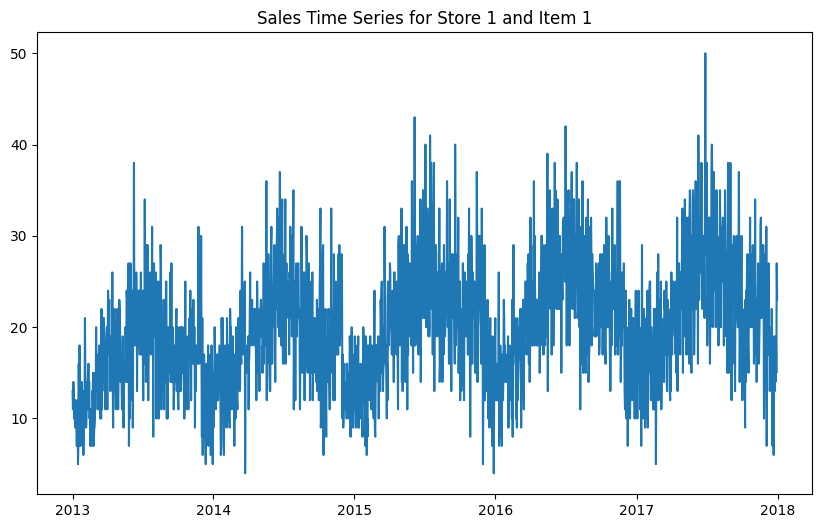

In [13]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(store_item_data)
plt.title('Sales Time Series for Store 1 and Item 1')
plt.show()

In [14]:
store_item_data = store_item_data.asfreq('D', method='pad')
# Fit ARIMA model
model = ARIMA(store_item_data['sales'], order=(5, 1, 0))  # Adjust (p, d, q) as needed
model_fit = model.fit()

In [15]:
# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1826
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5747.569
Date:                Tue, 23 Jul 2024   AIC                          11507.139
Time:                        20:01:41   BIC                          11540.195
Sample:                    01-01-2013   HQIC                         11519.333
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7223      0.023    -31.913      0.000      -0.767      -0.678
ar.L2         -0.6015      0.026    -22.847      0.000      -0.653      -0.550
ar.L3         -0.4961      0.027    -18.270      0.0

In [16]:
# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1826
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5747.569
Date:                Tue, 23 Jul 2024   AIC                          11507.139
Time:                        20:01:41   BIC                          11540.195
Sample:                    01-01-2013   HQIC                         11519.333
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7223      0.023    -31.913      0.000      -0.767      -0.678
ar.L2         -0.6015      0.026    -22.847      0.000      -0.653      -0.550
ar.L3         -0.4961      0.027    -18.270      0.0

In [17]:
# Forecast
forecast = model_fit.get_forecast(steps=10)  # Adjust steps as needed
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

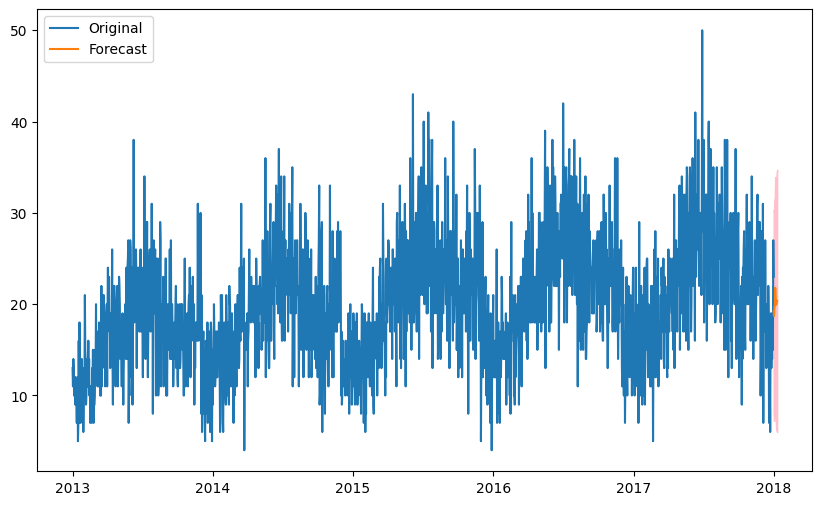

In [18]:
# Plot forecast
plt.figure(figsize=(10, 6))
plt.plot(store_item_data, label='Original')
forecast_index = pd.date_range(store_item_data.index[-1], periods=10, freq='D')
plt.plot(forecast_index, forecast_values, label='Forecast')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink')
plt.legend()
plt.show()

##**Multivariate Model**

In [19]:
# Aggregate data for multiple stores and items
store_item_data = data.pivot_table(index='date', columns=['store', 'item'], values='sales', aggfunc='sum').fillna(0)

In [20]:
# Ensure the data has a daily frequency
store_item_data = store_item_data.asfreq('D', method='pad')

In [21]:

# Select a smaller subset of columns (e.g., the first 5 store-item pairs)
store_item_data = store_item_data.iloc[:, :5]

In [22]:
# Flatten the MultiIndex columns
store_item_data.columns = ['store{}_item{}'.format(store, item) for store, item in store_item_data.columns]


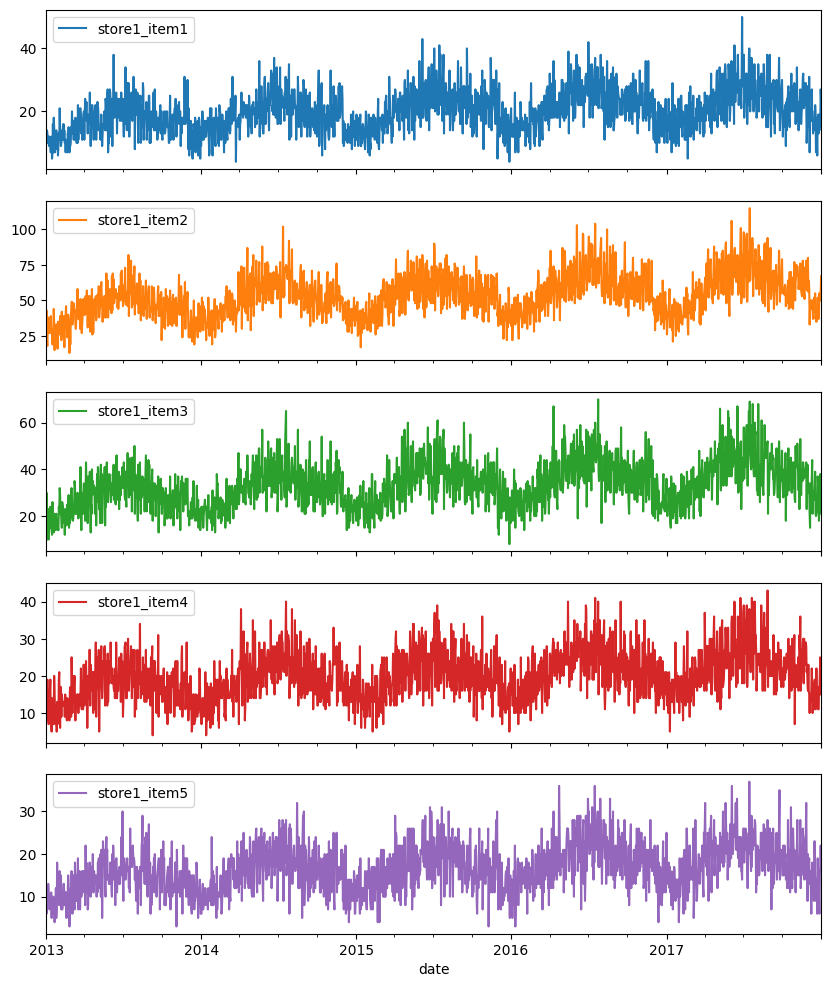

In [23]:
# Plot the time series for the selected store-item pairs
store_item_data.plot(subplots=True, figsize=(10, 12))
plt.show()

#**Ensemble Learning**

Random Forest MSE: 321.36616919876315
Gradient Boosting MSE: 381.3903313821225
Ensemble MSE: 315.62764636326614
   id  store  item  month  day  weekday  predicted_sales
0   0      1     1      1    1        0        15.498235
1   1      1     1      1    2        1        16.856759
2   2      1     1      1    3        2        16.841101
3   3      1     1      1    4        3        17.517115
4   4      1     1      1    5        4        18.627911


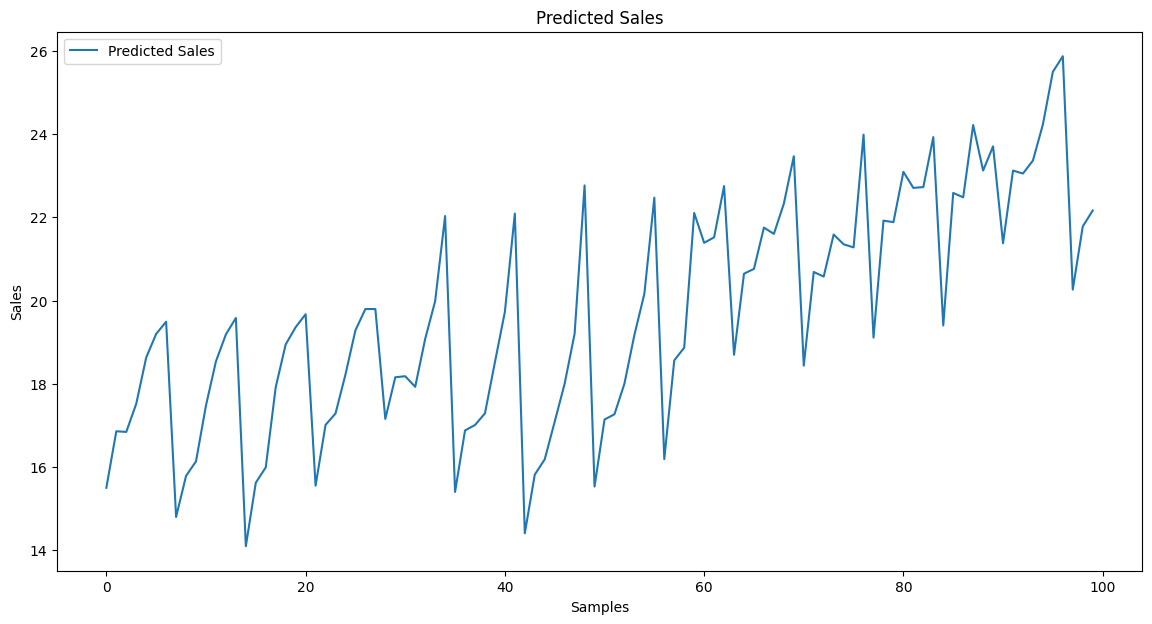

In [29]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the training data
train_data = pd.read_csv(r"C:\Users\HP\Downloads\train.csv\train.csv")

# Convert 'date' to datetime
train_data['date'] = pd.to_datetime(train_data['date'])

# Create additional date-related features
train_data['month'] = train_data['date'].dt.month
train_data['day'] = train_data['date'].dt.day
train_data['weekday'] = train_data['date'].dt.weekday

# Drop the original 'date' column
train_data = train_data.drop(columns=['date'])

# Check for missing values and fill if necessary
train_data = train_data.fillna(method='ffill')

# Define features and target
features = ['store', 'item', 'month', 'day', 'weekday']
target = 'sales'

# Downsample the data further to manage memory
train_data_sample = train_data.sample(frac=0.05, random_state=42)  # Reduced fraction to manage memory

# Define features and target for the downsampled data
X_train = train_data_sample[features]
y_train = train_data_sample[target]

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Initialize and train models with reduced complexity
rf = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)  # Reduced n_estimators and max_depth
gb = GradientBoostingRegressor(n_estimators=50, max_depth=3, random_state=42)  # Reduced n_estimators and max_depth

# Fit the models
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

# Predictions on the validation set
rf_preds_val = rf.predict(X_val)
gb_preds_val = gb.predict(X_val)

# Calculate Mean Squared Error
rf_mse_val = mean_squared_error(y_val, rf_preds_val)
gb_mse_val = mean_squared_error(y_val, gb_preds_val)

print(f"Random Forest MSE: {rf_mse_val}")
print(f"Gradient Boosting MSE: {gb_mse_val}")

# Ensemble predictions by averaging
ensemble_preds_val = (rf_preds_val + gb_preds_val) / 2

# Calculate MSE for the ensemble model
ensemble_mse_val = mean_squared_error(y_val, ensemble_preds_val)
print(f"Ensemble MSE: {ensemble_mse_val}")

# Load the test data
test_data = pd.read_csv(r"C:\Users\HP\Downloads\test.csv")

# Convert 'date' to datetime
test_data['date'] = pd.to_datetime(test_data['date'])

# Create additional date-related features
test_data['month'] = test_data['date'].dt.month
test_data['day'] = test_data['date'].dt.day
test_data['weekday'] = test_data['date'].dt.weekday

# Drop the original 'date' column
test_data = test_data.drop(columns=['date'])

# Define features for the test data
X_test = test_data[features]

# Predictions on the test data
rf_preds_test = rf.predict(X_test)
gb_preds_test = gb.predict(X_test)

# Ensemble predictions by averaging
ensemble_preds_test = (rf_preds_test + gb_preds_test) / 2

# Create a DataFrame for the results
test_data['predicted_sales'] = ensemble_preds_test

# Display the predictions
print(test_data.head())

# Plotting the predicted sales for visualization
plt.figure(figsize=(14, 7))
plt.plot(test_data['predicted_sales'][:100], label='Predicted Sales')
plt.xlabel('Samples')
plt.ylabel('Sales')
plt.title('Predicted Sales')
plt.legend()
plt.show()
